# Using Keras with TFRecords

### Configure the Environment

We begin by importing a number of useful libraries

In [89]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

### Earth Engine data acquisition

In [ ]:
# Central position of (AOIs)
points = [[-120.7224, 37.3872], [-112.6799, 42.9816], [-89.7649, 35.8764], 
          [-96.0181, 41.2412], [-115.473, 46.861], [-103.9803, 47.9713], 
          [-96.9217, 32.8958], [-82.986, 40.019], [-90.347, 38.668], 
          [-110.6947, 37.4568], [-101.8889, 33.5527], [-92.621, 33.417],
          [-80.352, 38.628], [-104.752, 43.972], [-110.92, 37.18]]

# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10
# Buffer
buffer = 40000

In [ ]:
from preprocess.ee_dataset_acquisition_TFRecord import ee_dataset

### Export `.TFRecord` files to Google Cloud Storage

In [ ]:
data = ee_dataset(points = points, buffer = buffer, startDate = startDate, stopDate = stopDate, 
                  scale = scale, patch_size = [256,256], file_name='AOI_TFRecord', 
                  collections = ['Sentinel2', 'CroplandDataLayers'])
data.export_toCloudStorage()

### Read `.tfrecord` files

In [3]:
from google.cloud import storage
client = storage.Client()
bucketname = 'skydipper_materials'
bucket = client.get_bucket(bucketname)

**Get the list of files in the bucket**

In [4]:
folder = 'gee_data_TFRecords/'
file_type = 'tfrecord.gz'

In [68]:
filelist = []
blobs = bucket.list_blobs(prefix=folder)
for blob in blobs:
    filelist.append(blob.name)   

files = [i for i in filelist if file_type in i]
files = ['gs://'+bucketname+'/'+i for i in files]

**Get number of records and the patch size**

In [90]:
files_json = [i for i in filelist if 'json' in i]

nRecords = 0
for file in files_json:
    blob = bucket.get_blob(file)
    blob.download_to_filename('data.json')
    
    with open('data.json') as f:
        data = json.load(f)
        
    nRecords += data.get('totalPatches')
    
patchSize = data.get('patchDimensions')

## Remove file
os.remove('data.json')

print('Number of Records:', nRecords)
print('Patch Size:', patchSize)

Number of Records: 18631
Patch Size: [256, 256]


**Read example record**

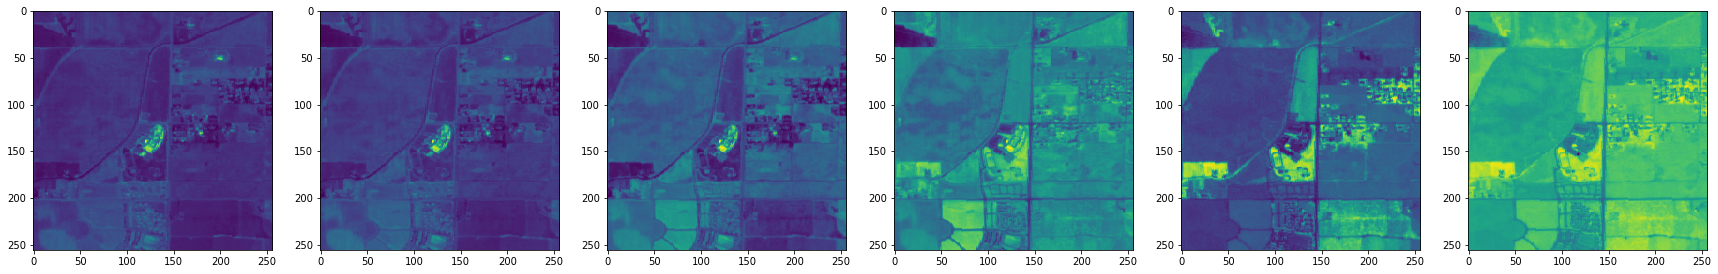

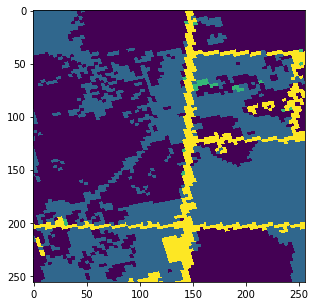

In [87]:
#nRecords = 0
options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
#for file in files[:1]:
#    print(file)
#    for record in tf.python_io.tf_record_iterator(file, options=options):
    
#        nRecords += 1

#print('Number of Records:', nRecords)

for record in tf.python_io.tf_record_iterator(files[0], options=options):
    
    example = tf.train.Example()
    
example.ParseFromString(record) # calling protocol buffer API

#image_B8 = np.array(example.features.feature['B8'].float_list.value).reshape(256,256)
bands = ['B2', 'B3', 'B4', 'B8', 'ndvi', 'ndwi']
image = np.concatenate([np.array(example.features.feature[i].float_list.value).reshape(256,256,1) for i in bands], axis=2)

band_cropland = example.features.feature['cropland'].bytes_list.value[0]
tensor_cropland = tf.reshape(tf.decode_raw(band_cropland, tf.uint8), [256,256])

sess = tf.Session()
with sess.as_default():
    image_cropland = tensor_cropland.eval()
    
fig, ax = plt.subplots(1,len(bands), figsize=(5*len(bands),5))
for i in range(len(bands)):
    ax[i].imshow(image[:,:,i])
    
plt.figure(figsize=(5,5))
plt.imshow(image_cropland);

### Create tf.data.Dataset from `TFRecord` files

In [8]:
def parse_function(proto):
    
    # Define your tfrecord 
    bands_input = ['B2', 'B3', 'B4', 'B8', 'ndvi', 'ndwi']
    columns_input = [tf.FixedLenFeature([256,256,1], tf.float32) for i in bands_input]

    bands_output = ['cropland']
    columns_output = [tf.FixedLenFeature([], tf.string) for i in bands_output]

    bands = bands_input + bands_output
    columns = columns_input + columns_output
    features = dict(zip(bands, columns))
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, features)
    
    # Separate the output images from the input images
    label = parsed_features.pop('cropland')
    image = tf.concat([parsed_features[i] for i in bands_input], axis=2)
    
    # Turn your saved image string into an array
    label = tf.decode_raw(label, tf.uint8)
    
    # Normalize
    image = tf.divide(image, 255.0)
    
    # Bring your picture back in shape
    label = tf.reshape(label, [256, 256])
    
    # Create a one hot array for your labels
    label = tf.one_hot(label, 4)
    
    return image, label

In [9]:
def create_dataset(filepath, shuffleSize, batchSize, nEpochs, nRecords, split=None):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type='GZIP')
    
    # This dataset will go on forever
    dataset = dataset.repeat(nEpochs)
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(parse_function, num_parallel_calls=8)
    
    # Set the number of datapoints you want to load and shuffle 
    if shuffleSize:
        dataset = dataset.shuffle(shuffleSize)
    
    # Set the batchsize
    dataset = dataset.batch(batchSize)
    
    # Split dataset into training and validation
    if split:
        train_size = int(0.7 * nRecords)
        val_size = int(0.3 * nRecords)
        
        train_dataset = dataset.take(train_size)
        val_dataset = dataset.skip(train_size)
        
        # Create an iterators
        train_iterator = train_dataset.make_one_shot_iterator()
        val_iterator = val_dataset.make_one_shot_iterator()
        
        return train_iterator, val_iterator 
    
    else:
        # Create an iterator
        iterator = dataset.make_one_shot_iterator()
    
        return iterator

In [ ]:
dataset = create_dataset(filepath=files, shuffleSize=nRecords, batchSize=4, 
                         nEpochs=1, nRecords=nRecords)

In [11]:
dataset_train, dataset_val = create_dataset(filepath=files, shuffleSize=nRecords, batchSize=4, 
                                             nEpochs=1, nRecords=nRecords, split=True)

In [94]:
print(dataset_train.get_next())

(<tf.Tensor 'IteratorGetNext_3:0' shape=(?, 256, 256, 6) dtype=float32>, <tf.Tensor 'IteratorGetNext_3:1' shape=(?, 256, 256, 4) dtype=float32>)


In [95]:
print(dataset_val.get_next())

(<tf.Tensor 'IteratorGetNext_4:0' shape=(?, 256, 256, 6) dtype=float32>, <tf.Tensor 'IteratorGetNext_4:1' shape=(?, 256, 256, 4) dtype=float32>)


In [ ]:
image, label = dataset.get_next()
sess = tf.Session()
with sess.as_default():
    label = label.eval()
    image = image.eval()
    
fig, ax = plt.subplots(1, 6, figsize=(30,5))
for i in range(6):
    ax[i].imshow(image[0,:,:,i])
fig, ax = plt.subplots(1, 4, figsize=(20,5))
for i in range(4):
    ax[i].imshow(label[0,:,:,i])

### Define model architecture

In [22]:
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Layer, Activation, Reshape, Permute
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.python.keras.optimizers import Adam 

In [23]:
def segnet(inputShape, nClasses):
    """
    SegNet model
    ----------
    inputShape : tuple
        Tuple with the dimensions of the input data (ny, nx, nBands). 
    nClasses : int
         Number of classes.
    """

    filter_size = 64
    kernel = (3, 3)        
    pad = (1, 1)
    pool_size = (2, 2)
        

    inputs = Input(shape=inputShape)
        
    # Encoder
    x = Conv2D(64, kernel, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
            
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
            
            
    # Decoder
    x = Conv2D(512, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(256, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(128, kernel, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size)(x)
            
    x = Conv2D(64, kernel, padding='same')(x)
    x = BatchNormalization()(x)
            
    x = Conv2D(nClasses, (1, 1), padding='valid')(x)
    
    outputs = Activation('softmax')(x)
        
    model = Model(inputs=inputs, outputs=outputs, name='segnet')
    
    model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
        
    return model

In [24]:
model = segnet(inputShape=(256, 256, 6), nClasses=4)

Instructions for updating:
Use tf.cast instead.


### Train model

In [25]:
nEpochs = 1
batchSize = 4
nStep = int(nRecords/batchSize)
nStep_train = int(int(0.7 * nRecords)/batchSize)
nStep_val = int((nRecords - int(0.7 * nRecords))/batchSize)

In [ ]:
model.fit(dataset, epochs=nEpochs, steps_per_epoch=nStep)

In [26]:
model.fit(dataset_train, epochs=nEpochs, validation_data=dataset_val, steps_per_epoch=nStep_train, validation_steps=nStep_val)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


KeyboardInterrupt: 

### Prediction

In [ ]:
files = ['gs://skydipper_materials/gee_data/AOI_TFRecord_test_00.tfrecord.gz']
options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)

nRecords = 0
for file in files:
    for record in tf.python_io.tf_record_iterator(file, options=options):
        nRecords += 1

print('Number of Records:', nRecords)

example = tf.train.Example()
example.ParseFromString(record) # calling protocol buffer API

image_B8 = np.array(example.features.feature['B8'].float_list.value).reshape(256,256)

band_cropland = example.features.feature['cropland'].bytes_list.value[0]
tensor_cropland = tf.reshape(tf.decode_raw(band_cropland, tf.uint8), [256,256])

sess = tf.Session()
with sess.as_default():
    image_cropland = tensor_cropland.eval()
    

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(image_cropland)
ax[1].imshow(image_B8);

In [ ]:
dataset_val = create_dataset(filepath=files, shuffleSize=None, batchSize=4, nEpochs=1)

In [ ]:
batchSize = 4
nStep = int(nRecords/batchSize)

In [ ]:
dataset_out = model.predict(dataset_val, steps=nStep, batch_size=batchSize)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
for i in range(4):
    ax[i].imshow(dataset_out[0,:,:,i])